In [1]:
datasetName = 'brain_FetalBrain6_Guo2020'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/brain_FetalBrain6_Guo2020")

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [3]:
row.names(data.matrix) <- data.matrix[, 1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,FetalBrain_6.TGCGGAGGTACAGATCTT,FetalBrain_6.CTGTGTGCTGTGCCTTTC,FetalBrain_6.AACCTAATCAACTGGATG,FetalBrain_6.ATCTCTAACGCCGTGGTA,FetalBrain_6.ATCTCTTGCGGAAAGTAC
,<int>,<int>,<int>,<int>,<int>
A1BG,0,0,0,0,0
A1BG-AS1,0,0,0,0,0
A2M,0,0,0,0,0
A2ML1,0,0,0,0,0
A2MP1,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
FetalBrain_6.TGCGGAGGTACAGATCTT,brain,FetalBrain,FetalBrain,normal,Donor11,female,11 weeks old
FetalBrain_6.CTGTGTGCTGTGCCTTTC,brain,FetalBrain,FetalBrain,normal,Donor11,female,11 weeks old
FetalBrain_6.AACCTAATCAACTGGATG,brain,FetalBrain,FetalBrain,normal,Donor11,female,11 weeks old
FetalBrain_6.ATCTCTAACGCCGTGGTA,brain,FetalBrain,FetalBrain,normal,Donor11,female,11 weeks old
FetalBrain_6.ATCTCTTGCGGAAAGTAC,brain,FetalBrain,FetalBrain,normal,Donor11,female,11 weeks old


[1] <NA>                 Fetal neuron         Fetal endocrine cell
[4] Fetal neuron         <NA>                
10 Levels: CB CD34+ Endothelial cell ... Stromal cell

In [4]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


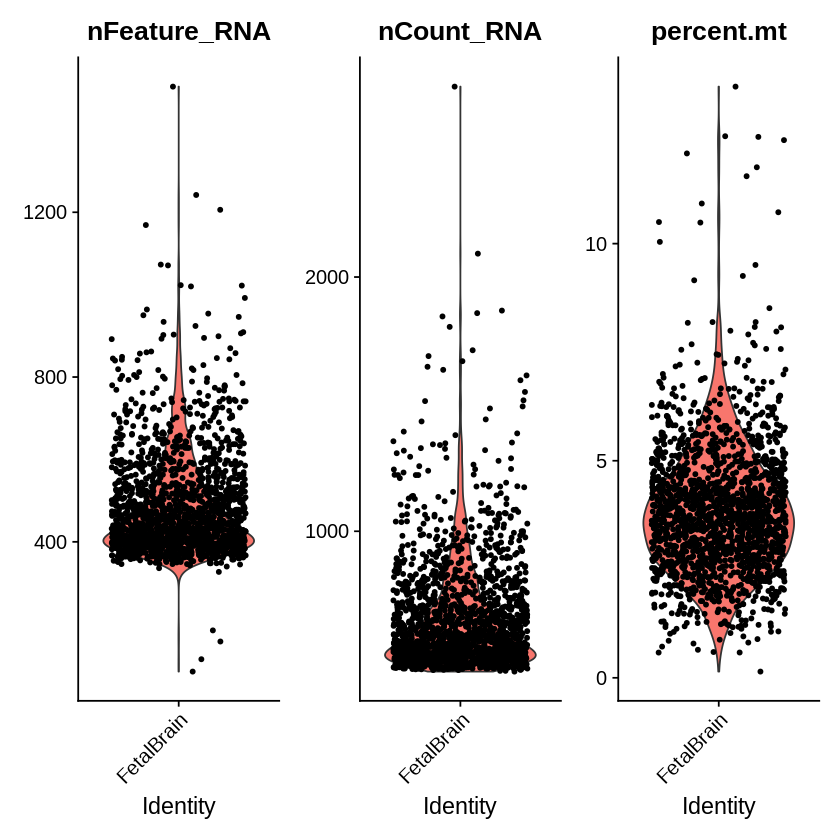

In [5]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [6]:
# QC
nFeature_RNA_range = c(200, 2500)
percent.mt.thre = 10
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)


In [7]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [8]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  STMN2, NEUROD6, TMSB10, RTN1, GPM6A, GAP43, TUBA1A, NEUROD2, ID2, HMP19 
	   MLLT11, UCHL1, CNTNAP2, NFIB, CSRP2, NSG1, ABRACL, KIDINS220, XPR1, MAPT 
	   TUBB2A, PPP2R2B, CALM1, TBR1, SYT4, BCL11B, SOX4, AKT3, DCX, AUTS2 
Negative:  HMGB2, UBE2C, PTTG1, CKS2, TOP2A, CDK1, NUSAP1, TUBA1B, CDC20, NUF2 
	   CCNB1, CCNB2, CKS1B, KPNA2, MAD2L1, AURKB, H2AFZ, HMGN2, BUB1B, HES1 
	   TUBA1C, SMC4, RACGAP1, LINC01158, VIM, UBE2T, CENPF, PBK, CDKN3, H2AFV 
PC_ 2 
Positive:  COL1A1, COL3A1, ISLR, OLFML3, S100A11, DCN, LUM, GJA1, ATP1A2, IFITM3 
	   PLTP, PMP22, COL1A2, SPARC, LGALS1, B2M, PTN, OGN, APOD, PTGDS 
	   ANXA2, VIM, COLEC12, FN1, CXCL12, MSX1, NID2, S100A6, VCAN, CRABP2 
Negative:  UBE2C, STMN1, KPNA2, PTTG1, TUBA1A, CCNB2, CALM2, CCNB1, NUSAP1, NEUROD6 
	   HMGB2, CKS2, MLLT11, CDC20, HMGB1, ARL6IP1, STMN2, CDK1, TMSB10, CKS1B 
	   AURKB, NUF2, BUB1B, MAD2L1, TUBA1C, PBK, UBE2T, KIF2C, FAM64A, TOP2A 
PC_ 3 
Positive:  COL3A1, COL1A1, ISLR, OLFML3, DCN, S100A11, TMS

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


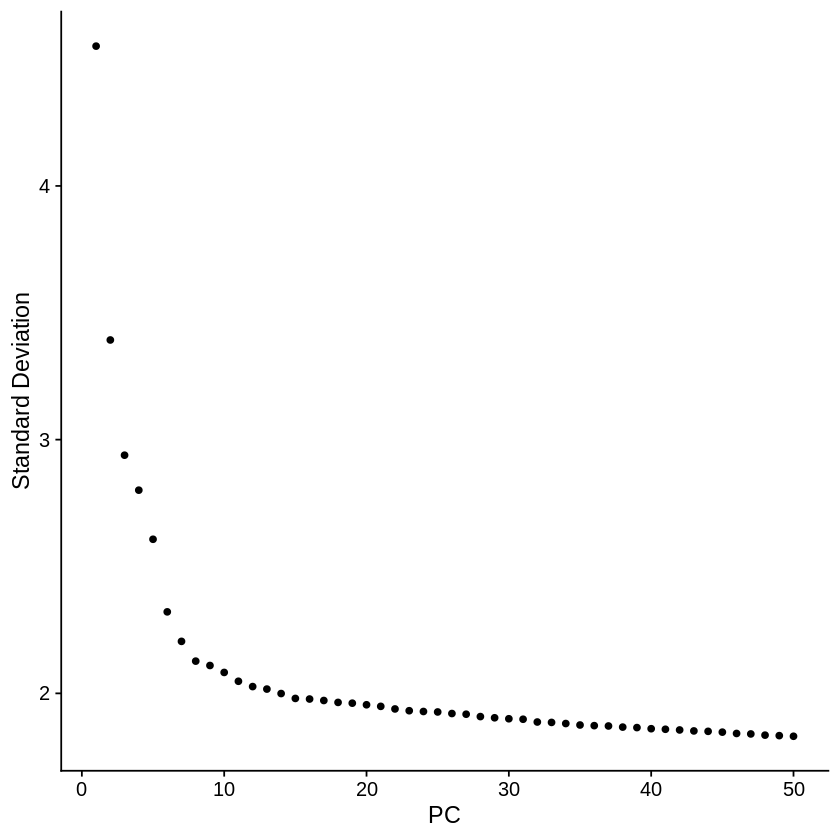

In [9]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [10]:
dev.off()
pcDim = 10 # set as 50 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
05:24:25 UMAP embedding parameters a = 0.9922 b = 1.112

05:24:25 Read 1705 rows and found 10 numeric columns

05:24:25 Using Annoy for neighbor search, n_neighbors = 30

05:24:25 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

05:24:25 Writing NN index file to temp file /tmp/Rtmpxtum4J/file71ab30693b8d

05:24:25 Searching Annoy index using 1 thread, search_k = 3000

05:24:26 Annoy recall = 100%

05:24:26 Commencing smooth kNN distance calibration using 1 thread

05:24:26 Initializing fr

In [11]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.6)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1705
Number of edges: 60824

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7652
Number of communities: 7
Elapsed time: 0 seconds


05:24:31 UMAP embedding parameters a = 0.9922 b = 1.112

05:24:31 Read 1705 rows and found 10 numeric columns

05:24:31 Using Annoy for neighbor search, n_neighbors = 30

05:24:31 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

05:24:31 Writing NN index file to temp file /tmp/Rtmpxtum4J/file71ab7363510d

05:24:31 Searching Annoy index using 1 thread, search_k = 3000

05:24:32 Annoy recall = 100%

05:24:32 Commencing smooth kNN distance calibration using 1 thread

05:24:32 Initializing from normalized Laplacian + noise

05:24:32 Commencing optimization for 500 epochs, with 67906 positive edges

05:24:37 Optimization finished



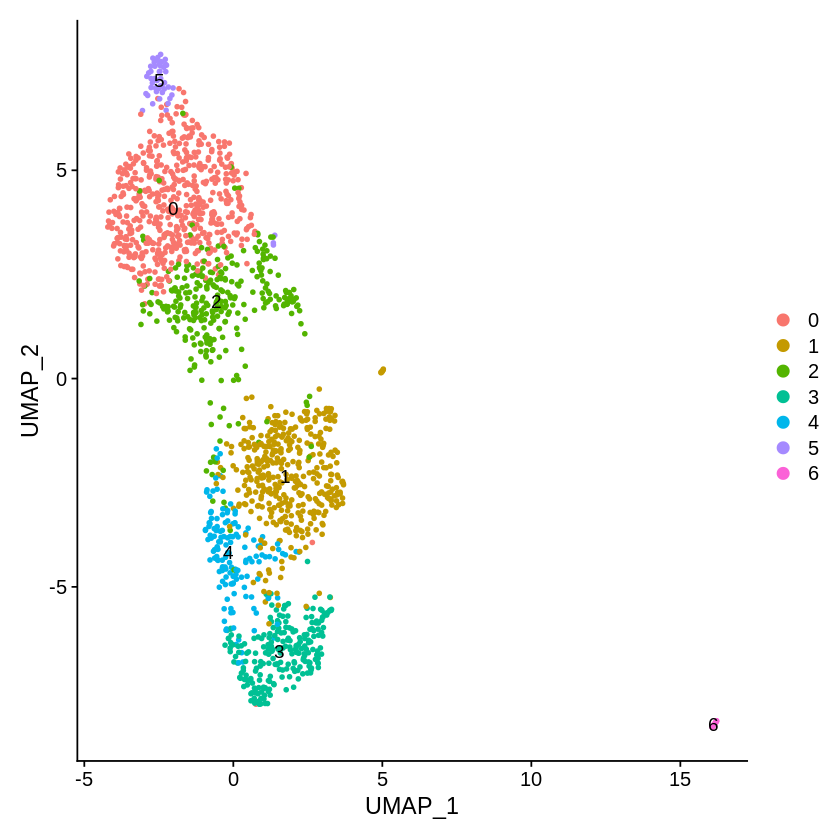

In [12]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [14]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

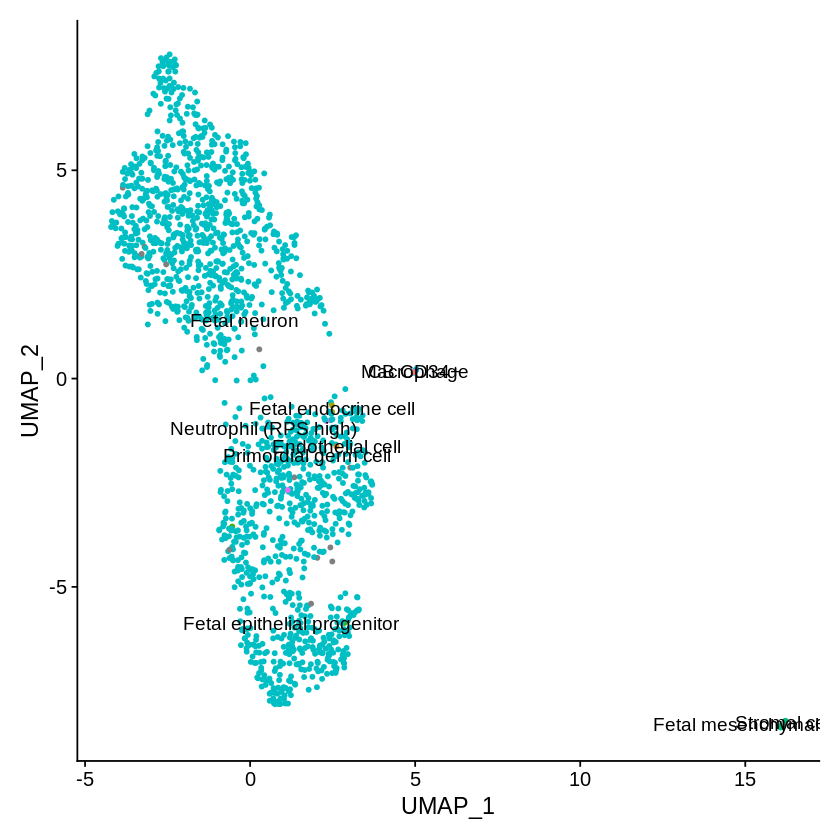

In [18]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1) + NoLegend()
p_umap2

In [15]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [16]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6



In [19]:
# proliferating radial glia? proliferating cell? erythroid cell?
new.cluster.ids <- c('Brain-Nerve tissue-Neuron-GAP43', 'Brain-Nerve tissue-Proliferating cell-KIAA0101', 'Brain-Nerve tissue-Neuron-GAP43',
                    'Brain-Nerve tissue-Proliferating cell-UBE2C', 'Brain-Nerve tissue-Proliferating cell-KIAA0101', 'Brain-Nerve tissue-Neuron-GAP43', 
                    'Unknown')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

In [12]:
new.cluster.ids <- c()
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

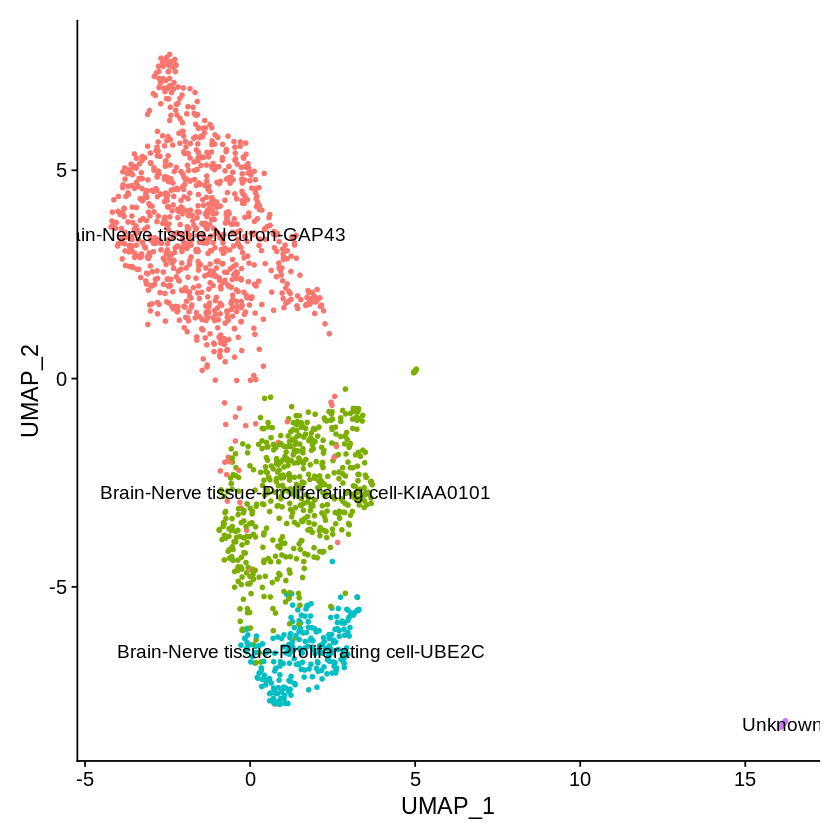

In [20]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [21]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [22]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))